# 1. Business understanding

## 1.1 Goal
Предсказать качество вина

## 1.2 Description
Необходимо научиться предсказывать качество вина по заданным параметрам, для того чтобы оптимизировать процесс производства вина и максимизировать выручк. Заведомо не тратя время на производство вина, качетсво которого с большой вероятносью будет не удовлетворительным.

# 2. Data Understanding

## 2.1 Import Libraries

In [3]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Handle table-like data and matrices
import numpy as np
import pandas as pd

#Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

#Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix 

#Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

# data description 
from pandas_profiling import ProfileReport

## 2.2 Auxiliary function

In [37]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=(  df[ var ].min() , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [4]:
data = pd.read_csv("/Users/user/Desktop/netology/customers/hw_4/data.csv")

## 2.4 Статистика и визуализации

In [19]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [33]:
data.shape

(6497, 13)

In [34]:
# есть не очень много незаполненных элементов
data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [26]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [23]:
profile = ProfileReport(data)
profile

Number of variables,13
Number of observations,6497
Total Missing (%),0.0%
Total size in memory,660.0 KiB
Average record size in memory,104.0 B
Numeric,12
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


## 2.4.1 Key informations

Крайне плохих вин (3-4) как и крайне хороших (8-9) очень мало. Но не смотря на это, плохих все таки больше.

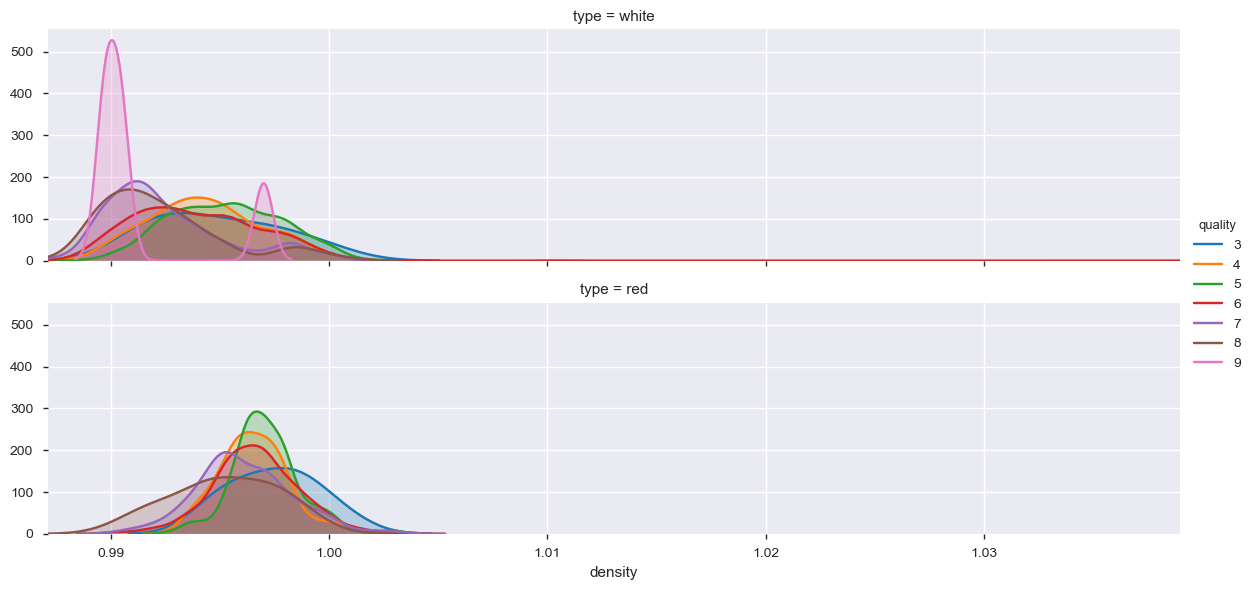

In [39]:
# Plot distributions density
plot_distribution( data , var = 'density' , target = 'quality' , row = 'type' )

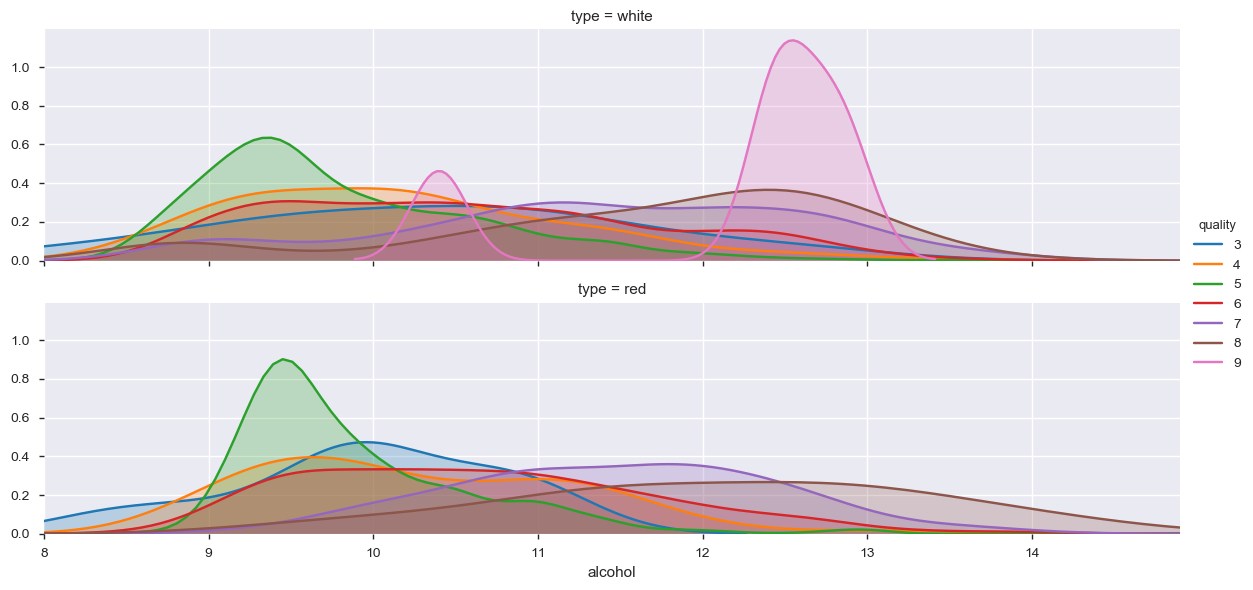

In [40]:
# Plot distributions alcohol
plot_distribution( data , var = 'alcohol' , target = 'quality' , row = 'type' )

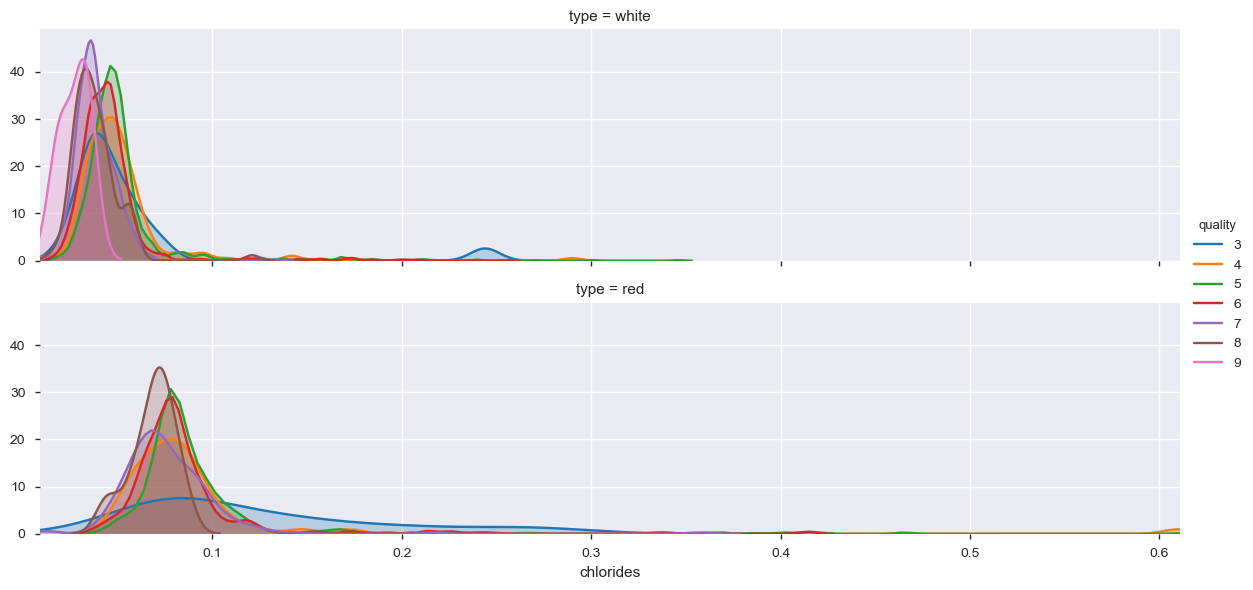

In [41]:
# Plot distributions chlorides
plot_distribution( data , var = 'chlorides' , target = 'quality' , row = 'type' )

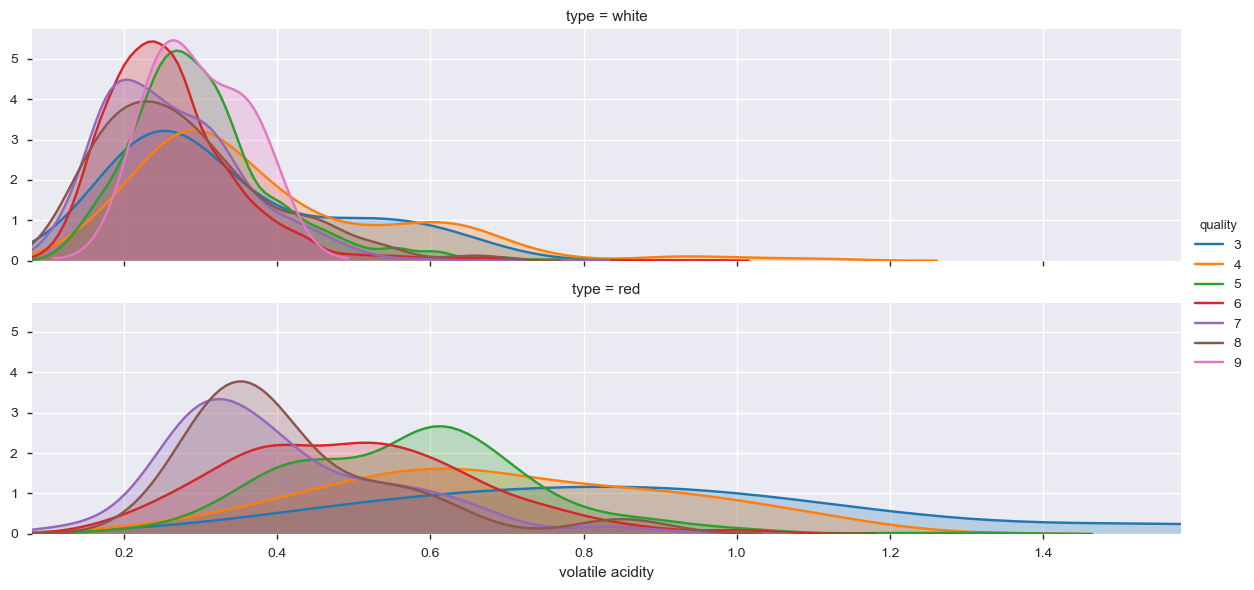

In [42]:
# Plot distributions volatile acidity
plot_distribution( data , var = 'volatile acidity' , target = 'quality' , row = 'type' )

# 3. Data Preparation

## 3.1 Data transformation (categorical signs)


In [53]:
data['is red'] = (data['type'] == 'red').astype('int')
data.drop('type', axis = 1, inplace=True)
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is red
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,0
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,0
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,0
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6,1
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1


## 3.2 Remove nan 

In [56]:
data[data['pH'].isnull()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is red
54,6.8,0.200,0.59,0.9,0.147,38.0,132.0,0.99300,NaN,0.38,9.1,6,0
139,8.1,0.280,0.39,1.9,0.029,18.0,79.0,0.99230,NaN,0.52,11.8,6,0
440,6.7,0.220,0.37,1.6,0.028,24.0,102.0,0.99130,NaN,0.59,11.6,7,0
587,6.1,0.320,0.25,1.7,0.034,37.0,136.0,0.99200,NaN,0.50,10.8,7,0
697,7.5,0.310,0.51,14.8,0.039,62.0,204.0,0.99820,NaN,0.60,9.5,5,0
972,6.8,0.220,0.35,17.5,0.039,38.0,153.0,0.99940,NaN,0.42,9.0,6,0
4892,6.5,0.230,0.38,1.3,0.032,29.0,112.0,0.99298,NaN,0.54,9.7,5,0
6428,NaN,0.440,0.09,2.2,0.063,9.0,18.0,0.99444,NaN,0.69,11.3,6,1
6429,NaN,0.705,0.10,2.8,0.081,13.0,28.0,0.99631,NaN,0.66,10.2,5,1


In [58]:
data[data['fixed acidity'].isnull()]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is red
17,NaN,0.660,0.48,1.2,0.029,29.0,75.0,0.98920,3.33,0.39,12.8,8,0
174,NaN,0.270,0.31,17.7,0.051,33.0,173.0,0.99900,3.09,0.64,10.2,5,0
249,NaN,0.410,0.14,10.4,0.037,18.0,119.0,0.99600,3.38,0.45,10.0,5,0
267,NaN,0.580,0.07,6.9,0.043,34.0,149.0,0.99440,3.34,0.57,9.7,5,0
368,NaN,0.290,0.48,2.3,0.049,36.0,178.0,0.99310,3.17,0.64,10.6,6,0
518,NaN,0.130,0.28,1.9,0.050,20.0,78.0,0.99180,3.43,0.64,10.8,6,0
1079,NaN,NaN,0.29,6.2,0.046,29.0,227.0,0.99520,3.29,0.53,10.1,6,0
2902,NaN,0.360,0.14,8.9,0.036,38.0,155.0,0.99622,3.27,NaN,9.4,5,0
6428,NaN,0.440,0.09,2.2,0.063,9.0,18.0,0.99444,NaN,0.69,11.3,6,1
6429,NaN,0.705,0.10,2.8,0.081,13.0,28.0,0.99631,NaN,0.66,10.2,5,1


In [59]:
data[data['volatile acidity'].isnull()]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is red
86,7.2,NaN,0.63,11.0,0.044,55.0,156.0,0.99740,3.09,0.44,8.7,6,0
521,7.9,NaN,0.26,2.1,0.039,8.0,143.0,0.99420,3.05,0.74,9.8,5,0
621,6.5,NaN,0.43,8.9,0.083,50.0,171.0,0.99650,2.85,0.50,9.0,5,0
812,6.4,NaN,0.28,1.1,0.055,9.0,160.0,0.99405,3.42,0.50,9.1,7,0
1079,NaN,NaN,0.29,6.2,0.046,29.0,227.0,0.99520,3.29,0.53,10.1,6,0
2894,6.4,NaN,0.36,1.4,0.044,22.0,68.0,0.99014,3.15,0.50,11.7,7,0
4895,6.5,NaN,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
6486,7.2,NaN,0.33,2.5,0.068,34.0,102.0,0.99414,3.27,0.78,12.8,6,1


In [60]:
data[data['sulphates'].isnull()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is red
224,6.3,0.495,0.22,1.8,0.046,31.0,140.0,0.99290,3.39,NaN,10.4,6,0
2902,NaN,0.360,0.14,8.9,0.036,38.0,155.0,0.99622,3.27,NaN,9.4,5,0
6321,6.4,0.530,0.09,3.9,0.123,14.0,31.0,0.99680,3.50,NaN,11.0,4,1
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6,1


In [62]:
data[data['citric acid'].isnull()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is red
268,5.3,0.585,NaN,7.1,0.044,34.0,145.0,0.9945,3.34,0.57,9.7,6,0
909,7.5,0.240,NaN,13.0,0.049,46.0,217.0,0.9985,3.08,0.53,8.8,5,0
6320,7.0,0.540,NaN,2.1,0.079,39.0,55.0,0.9956,3.39,0.84,11.4,6,1


In [63]:
data[data['residual sugar'].isnull()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is red
33,6.2,0.120,0.34,NaN,0.045,43.0,117.0,0.9939,3.42,0.51,9.0,6,0
438,7.4,0.155,0.34,NaN,0.045,73.5,214.0,0.9934,3.18,0.61,9.9,7,0


In [64]:
data[data['chlorides'].isnull()]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is red
98,9.8,0.36,0.46,10.5,NaN,4.0,83.0,0.9956,2.89,0.30,10.1,4,0
747,7.2,0.29,0.40,7.6,NaN,56.0,177.0,0.9928,3.04,0.32,11.5,6,0


In [65]:
# тк никаких особеннойстей и старнностей в пропущенных значениях нет их можн проосто удалить

In [70]:
data = data.dropna()
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is red
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,0
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,0
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,0
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1


## 3.3 Feature Engineering 


In [74]:
data['is low alcohol'] = (data['alcohol'] < 10).astype(int)
data['is high alcohol'] = (data['alcohol'] > 12).astype(int)
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is red,is low alcohol,is high alcohol
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,0,1,0
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,0,1,0
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,0,0,0
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0,1,0
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1,1,0
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1,0,0
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1,0,0
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1,0,0


## 3.4 Getting of final modeling datasets

In [77]:
# - 'alcohol'
data_X = data[['fixed acidity',
            'volatile acidity',
            'citric acid',
            'residual sugar',
            'chlorides',
            'free sulfur dioxide',
            'total sulfur dioxide',
            'density',
            'pH', 'sulphates', 
            'is red', 
            'is low alcohol',
            'is high alcohol']]

data_y = data['quality']


In [78]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=30)

# 4. Modeling
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Model selection
Хорошей отправной точкой является логистическая регрессия.

In [79]:
model = LogisticRegression()

## 4.2 Model fitting

In [81]:
model.fit( X_train , y_train )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# 5. Assessment
Теперь мы собираемся оценить модель

Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [82]:
# Score the model
print (model.score( X_train , y_train ) , model.score( X_test , y_test ))

0.5323017408123791 0.5127610208816705


In [85]:
confusion_matrix(y_train, model.predict(X_train))

array([[   0,    0,   16,    9,    0,    0,    0],
       [   0,    1,  101,   68,    0,    0,    0],
       [   0,    0, 1050,  651,    4,    0,    0],
       [   0,    0,  581, 1602,   75,    0,    0],
       [   0,    0,   58,  700,   99,    0,    0],
       [   0,    0,    9,  117,   25,    0,    0],
       [   0,    0,    0,    3,    1,    0,    0]])

In [88]:
confusion_matrix(y_test, model.predict(X_test))

array([[  0,   0,   2,   3,   0,   0,   0],
       [  0,   1,  22,  19,   2,   0,   0],
       [  0,   0, 258, 165,   0,   0,   0],
       [  0,   0, 159, 387,  16,   0,   0],
       [  0,   0,  20, 180,  17,   0,   0],
       [  0,   0,   1,  34,   6,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0]])

# 6. Развертывание

В данном случае этого этапа нет.